In [1]:
# --- MUST be first matplotlib cell in the notebook ---
import matplotlib
matplotlib.use('nbAgg')              # interactive backend for classic Notebook 5.x
%matplotlib notebook
print("Matplotlib backend:", matplotlib.get_backend())


Matplotlib backend: nbAgg


In [2]:
import sys
import pickle
import numpy as np
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()  # if not use with this line, "AttributeError: 'int' object has no attribute 'value'" 
# tf.disable_eager_execution()
import PIL.Image
#%matplotlib inline
#import matplotlib.pyplot as plt

##### Set the path of code folder containing GANSim codes

In [3]:
new_path = r'/home/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/3_3_2_GANSimTraining(Latent8)/' 
sys.path.append(new_path)

### 1. Load test dataset

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [4]:
data_dir_test = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/PreparedDataset/'

In [5]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset

test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', 
                                 cond_label = True, cond_well = True, cond_prob = True,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# loaded labels (global features) have been normalized into -1 to 1
test_dict = test_set.get_minibatch_np(minibatch_size = 1000, lod = 0)  
facies_test = test_dict['real']
labels_test = test_dict['label']
probimgs_test = test_dict['prob']
wellfaciesimgs_test = test_dict['well']


# Denormalize the global features back into its orginal range 
orit_one_hot = labels_test[:, :30]
orit_class = np.argmax(orit_one_hot, axis = 1)
mudprop = labels_test[:, 30] 
mudprop = (mudprop / 2 + 0.5) * 0.8037 + 0.1677
width = labels_test[:, 31] 
width = (width / 2 + 0.5) * 8 + 27
wvl = labels_test[:, 32]
wvl = (wvl / 2 + 0.5) * 63 + 100
amplt = labels_test[:, 33]
amplt = (amplt / 2 + 0.5) * 104 + 7

print(facies_test.shape)
print(orit_one_hot.shape)
print(orit_class.shape)
print(mudprop.shape)
print(width.shape)
print(wvl.shape)
print(amplt.shape)
print(probimgs_test.shape)
print(wellfaciesimgs_test.shape)

Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
(1000, 1, 64, 64)
(1000, 30)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000, 2, 64, 64)
(1000, 1, 64, 64)


### 2. Train and load trained conditional generator

In [6]:
GANSim_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/2DChannel/0_Data/GANSim_cond_gf_well_prob/LatentVector8/'
GANSim_name = 'network-snapshot-015360.pkl'   # 13440

# Initialize TensorFlow session.
tf.InteractiveSession()

with tf.device('/gpu:0'):   
    # Import Generator.
    with open(GANSim_dir+GANSim_name, 'rb') as file:
        _, _, Gs_Gansim = pickle.load(file)     

print(Gs_Gansim.input_shapes)
print(Gs_Gansim.output_shapes)


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[[None, 8, 8, 8], [None, 34, 64, 64], [None, 2, 64, 64], [None, 2, 64, 64]]
[[None, 3, 64, 64]]


#### Make 

<IPython.core.display.Javascript object>


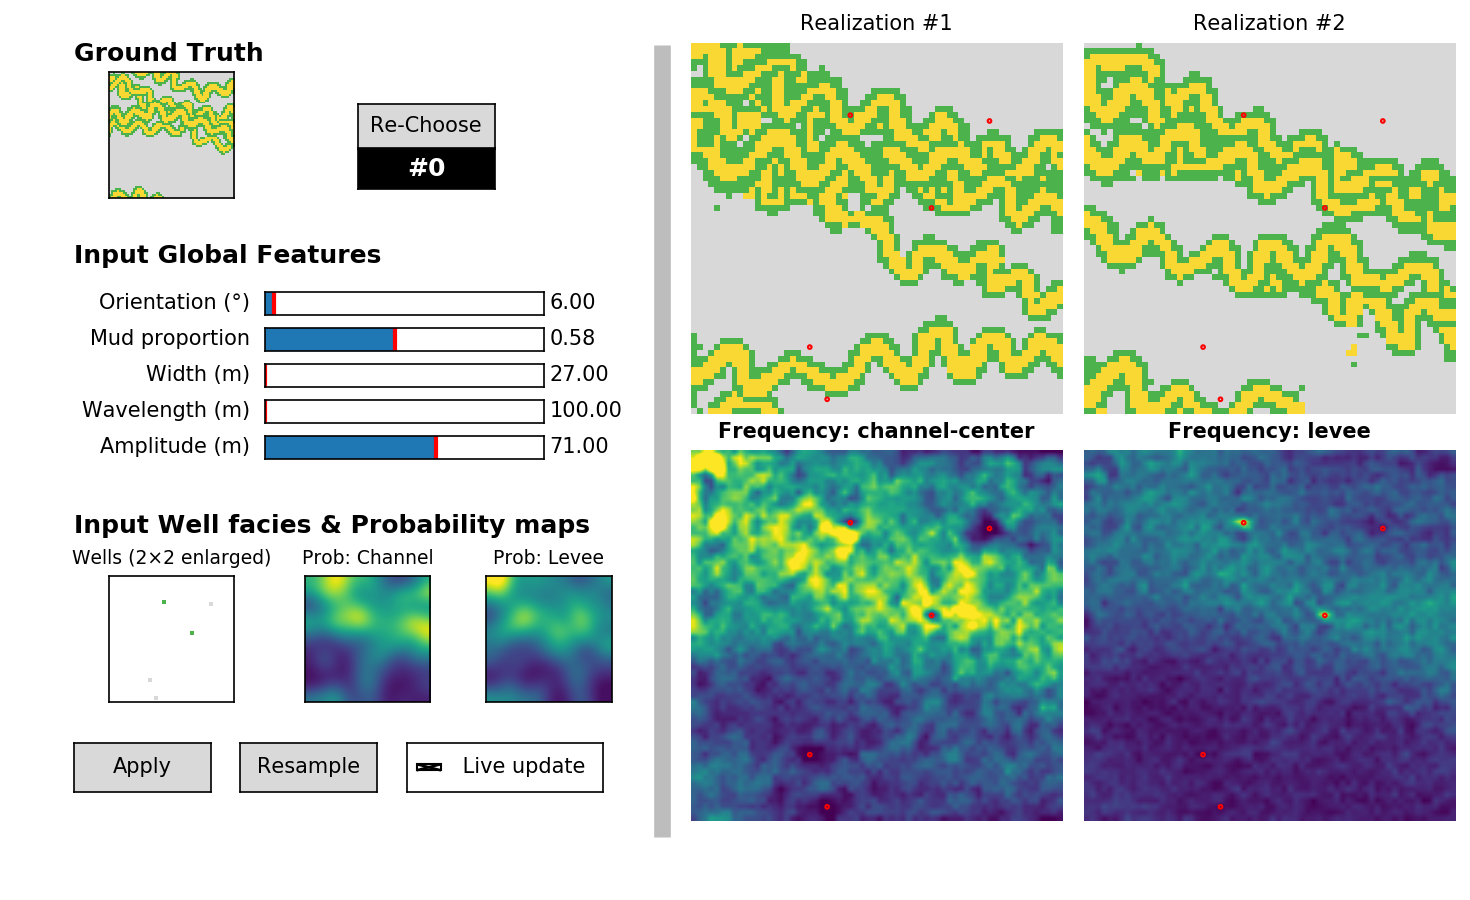

In [28]:
# ==== Imports ====
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, CheckButtons
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

# ========== Helper fns (same normalization) ==========
def norm_features(mudprop, width, wvl, amplt):
    width_n   = ((width   - 27)    / 8    - 0.5) * 2
    amplt_n   = ((amplt   - 7)     / 104  - 0.5) * 2
    wvl_n     = ((wvl     - 100)   / 63   - 0.5) * 2
    mudprop_n = ((mudprop - 0.1677) / 0.8037 - 0.5) * 2
    return mudprop_n, width_n, wvl_n, amplt_n

def inv_norm_features(mudprop_n, width_n, wvl_n, amplt_n):
    """Invert the normalization above."""
    width   = 31.0  + 4.0  * width_n
    amplt   = 59.0  + 52.0 * amplt_n
    wvl     = 131.5 + 31.5 * wvl_n
    mudprop = 0.56955 + 0.40185 * mudprop_n
    return mudprop, width, wvl, amplt

def build_label(orientation_deg, mudprop, width, wvl, amplt):
    cls = int(np.clip(np.floor(orientation_deg / 6.0), 0, 29))  # 30 classes across 0–180°
    one_hot = np.zeros(30, dtype=np.float32); one_hot[cls] = 1.0
    m, w, wl, a = norm_features(mudprop, width, wvl, amplt)
    return np.concatenate([one_hot, [m, w, wl, a]]).astype(np.float32)  # (34,)

def vector_to_maps(label_vec, H=64, W=64, B=4):
    lab_hw = np.broadcast_to(label_vec[:, None, None], (label_vec.shape[0], H, W)).astype(np.float32)  # (34,H,W)
    return np.broadcast_to(lab_hw[None, ...], (B, lab_hw.shape[0], H, W)).copy()                       # (B,34,H,W)

# ---- 2x2 enlargement (NumPy) ----
def _shift(mask, di, dj):
    out = np.zeros_like(mask, dtype=bool)
    i0 = max(0, di); i1 = mask.shape[0] + min(0, di)
    j0 = max(0, dj); j1 = mask.shape[1] + min(0, dj)
    out[i0:i1, j0:j1] = mask[i0-di:i1-di, j0-dj:j1-dj]
    return out

def enlarge_2x2_wells(wells_1p, n_classes=3):
    """wells_1p: (2,H,W) [loc 0/1, facies_id 0..K-1] → 2×2 dilation."""
    loc = wells_1p[0] > 0.5
    fc  = wells_1p[1].astype(np.int32)
    loc_big = (loc | _shift(loc,1,0) | _shift(loc,0,1) | _shift(loc,1,1))
    fc_big = np.zeros_like(fc)
    for c in range(n_classes):
        m = (fc==c) & loc
        m_big = (m | _shift(m,1,0) | _shift(m,0,1) | _shift(m,1,1))
        fc_big[m_big] = c
    return np.stack([loc_big.astype(np.float32), fc_big.astype(np.float32)], axis=0)

# ========== Batch / geometry / colors ==========
B, H, W, C = 4, 64, 64, 3
Z_SHAPE = (8, 8, 8)  # change to (8,4,4) if your G uses that

# How many realizations we generate per render (single forward pass)
K_SAMPLES = 50

# --- Fixed latent pool (stays constant across slider changes) ---
LATENT_SEED = rng.randint(0, 1_000_000)

def _build_latent_pool(seed):
    rs = np.random.RandomState(int(seed))
    return rs.randn(K_SAMPLES, *Z_SHAPE).astype(np.float32)

latents_pool = _build_latent_pool(LATENT_SEED)

# Which two realizations to show in the left-top (0) and right-top (1) panels
ridx_pair = rng.choice(K_SAMPLES, size=2, replace=False)

# Cache for last forward pass (so Resample can redraw without recompute)
last_cls = None          # (K_SAMPLES, H, W) class maps
last_freq_lev = None     # (H, W) levee frequency
last_freq_ch  = None     # (H, W) channel-center frequency

rng = np.random.RandomState(412)

bg_gray   = [0.85, 0.85, 0.85]
levee_grn = [0.30, 0.70, 0.30]
center_yl = [0.98, 0.85, 0.20]
facies_cmap = ListedColormap([bg_gray, levee_grn, center_yl])      # for GT + realizations
facies_cmap_well = ListedColormap([bg_gray, levee_grn, center_yl]) # white outside wells
facies_cmap_well.set_bad(color='white')
prob_cmap = plt.cm.viridis

# ========== Distinct latents per realization ==========
def _latents_from_seeds(seeds, z_shape=Z_SHAPE):
    return np.stack([np.random.RandomState(int(s)).randn(*z_shape).astype(np.float32) for s in seeds], axis=0)
seeds = rng.randint(0, 1_000_000, size=B)
latents_fixed = _latents_from_seeds(seeds)

# ========== Dataset hooks ==========
N_TEST = facies_test.shape[0]   # expects facies_test: (N,1,64,64)

def sample_wells_from_gt(gt_map_12, ssd=1):
    wp = np.zeros((1, 1, H, W), dtype=np.int8)
    npts = np.random.RandomState(3 * ssd + ssd * ssd).choice(np.arange(1, 11), 1)[0]
    xs   = np.random.RandomState(123 * ssd).choice(H, npts)
    ys   = np.random.RandomState(3 * ssd + ssd * ssd).choice(W, npts)
    wp[0, 0, xs, ys] = 1
    wf  = gt_map_12[None, None, :, :] * wp
    wf  = wf + wp
    loc = (wf > 0).astype(np.float32)
    fc  = (wf - 1) * loc
    return np.concatenate([loc, fc], axis=1)[0]  # (2,H,W)

def get_prob_pair(idx):
    arr = probimgs_test[idx]  # expects (2,64,64): [channel, levee]
    if arr.shape[0] == 2:
        prob_channel, prob_levee = arr[0].astype(np.float32), arr[1].astype(np.float32)
    elif arr.shape[0] >= 3:
        prob_channel, prob_levee = arr[2].astype(np.float32), arr[1].astype(np.float32)
    else:
        prob_channel = np.zeros((H,W), np.float32); prob_levee = np.zeros((H,W), np.float32)
    return prob_channel, prob_levee

# Optional: fetch GT global features from a labels tensor if available
def gt_globals_from_labels(idx):
    """Return (deg, mud, width, wvl, amplt) in real units, or None if unavailable."""
    lab = labels_test[idx]                           # (>=34)
    onehot = lab[0:30]                  # average to be robust
    cls = int(np.argmax(onehot))
    deg = cls * 6.0                                      # bin lower edge; good enough for marker
    m_n, w_n, wl_n, a_n = [float(lab[30+i]) for i in range(4)]
    mud, width, wvl, amplt = inv_norm_features(m_n, w_n, wl_n, a_n)
    return deg, mud, width, wvl, amplt

# ========== Figure: neat left panel; right realizations ==========
fig, axes = plt.subplots(2, 2, figsize=(9.8, 6.0))
plt.subplots_adjust(left=0.47, right=0.99, bottom=0.08, top=0.96, hspace=0.06, wspace=0.06)
for ax in axes.flat: ax.axis('off')

# Left panel geometry
x_panel, w_panel = 0.05, 0.34
def _label(ax_rect, text, size=10, bold=False, align='left'):
    ax = plt.axes(ax_rect, frameon=False); ax.set_xticks([]); ax.set_yticks([])
    ax.text(0.0 if align=='left' else 1.0, 0.5, text,
            ha=align, va='center', fontsize=size, fontweight=('bold' if bold else 'normal'))
    return ax

# --- Ground Truth section ---
_label([x_panel, 0.925, w_panel, 0.03], 'Ground Truth', size=12, bold=True, align='left')

tile_h = 0.14
tile_w = (w_panel - 0.06) / 3.0

ax_gt   = plt.axes([x_panel + 0.02,               0.78,  tile_w, tile_h]); ax_gt.set_xticks([]); ax_gt.set_yticks([])
ax_gtbtn= plt.axes([x_panel + 0.1 + tile_w,       0.835, tile_w*1.0, 0.05])
ax_gtbox= plt.axes([x_panel + 0.1 + tile_w,       0.790, tile_w*1.0, 0.045], facecolor='black')
ax_gtbox.set_xticks([]); ax_gtbox.set_yticks([])

btn_rechoose = Button(ax_gtbtn, 'Re-Choose')  # randomize GT sample
def _set_sample_box(idx):
    ax_gtbox.clear()
    ax_gtbox.set_facecolor('black'); ax_gtbox.set_xticks([]); ax_gtbox.set_yticks([])
    ax_gtbox.text(0.5, 0.5, f'#{idx}', ha='center', va='center',
                  color='white', fontsize=12, fontweight='bold')

# Divider
fig.add_artist(Line2D([0.45, 0.45], [0.07, 0.95], transform=fig.transFigure,
                      color='#bdbdbd', linewidth=8, solid_capstyle='butt', zorder=3))

# --- Input Global Features (right-aligned labels, tight gaps, GT markers) ---
_label([x_panel, 0.70, w_panel, 0.03], 'Input Global Features', size=12, bold=True, align='left')

w_label = 0.12
gap = 0.010
w_slider = w_panel - w_label - gap - 0.02
y = 0.65
row_h, row_gap = 0.026, 0.040

def _rlabel(ypos, text):
    _label([x_panel, ypos, w_label, row_h], text, size=10, bold=False, align='right')
    return plt.axes([x_panel + w_label + gap, ypos, w_slider, row_h])

ax_deg = _rlabel(y, 'Orientation (°)'); y -= row_gap
ax_mud = _rlabel(y, 'Mud proportion');  y -= row_gap
ax_wd  = _rlabel(y, 'Width (m)');       y -= row_gap
ax_wl  = _rlabel(y, 'Wavelength (m)');  y -= row_gap
ax_amp = _rlabel(y, 'Amplitude (m)')

# default values will be overwritten by GT in _refresh_inputs()
s_deg = Slider(ax_deg, '', 0, 180,   valinit=84,   valstep=6)
s_mud = Slider(ax_mud, '', 0.35, 0.85, valinit=0.65, valstep=0.01)
s_wd  = Slider(ax_wd,  '', 27, 35,    valinit=31,   valstep=1)
s_wl  = Slider(ax_wl,  '', 100, 160,  valinit=120,  valstep=1)
s_amp = Slider(ax_amp, '', 7,  111,   valinit=55,   valstep=1)

def _mark_slider(slider, gt_val):
    """Hide default notch; draw red (GT) and green (-40%, +40%) markers."""
    try:
        slider.vline.set_visible(False)
    except Exception:
        pass
    # clear old marks
    if hasattr(slider, "_marks"):
        for ln in slider._marks:
            try: ln.remove()
            except Exception: pass
    slider._marks = []
    ax = slider.ax
    lo, hi = slider.valmin, slider.valmax
    lo_g = max(lo, 0.6 * gt_val)
    hi_g = min(hi, 1.4 * gt_val)
    slider._marks.append(ax.axvline(gt_val, color='red',   lw=2))
    #slider._marks.append(ax.axvline(lo_g,  color='green', lw=1.8))
    #slider._marks.append(ax.axvline(hi_g,  color='green', lw=1.8))

# --- One row: Wells (2×2) | Prob Channel | Prob Levee ---
_label([x_panel, 0.40, w_panel, 0.03], 'Input Well facies & Probability maps', size=12, bold=True, align='left')

row_y = 0.22
ax_well = plt.axes([x_panel + 0.02,            row_y, tile_w, tile_h]); ax_well.set_xticks([]); ax_well.set_yticks([])
ax_pch  = plt.axes([x_panel + 0.06 + tile_w,   row_y, tile_w, tile_h]); ax_pch.set_xticks([]);  ax_pch.set_yticks([])
ax_plv  = plt.axes([x_panel + 0.09 + 2*tile_w, row_y, tile_w, tile_h]); ax_plv.set_xticks([]);  ax_plv.set_yticks([])
ax_well.set_title('Wells (2×2 enlarged)', fontsize=9)
ax_pch.set_title('Prob: Channel',          fontsize=9)
ax_plv.set_title('Prob: Levee',            fontsize=9)

# Bottom row: Apply | Resample | Live update
bx = x_panel; bw = (w_panel - 0.06)/3.0; by = 0.12; bh = 0.055
ax_apply  = plt.axes([bx,             by, bw, bh])
ax_resamp = plt.axes([bx + bw + 0.02, by, bw, bh])
ax_live   = plt.axes([bx + 2*bw + 0.04, by, bw+0.04, bh])
btn_apply  = Button(ax_apply,  'Apply')
btn_resamp = Button(ax_resamp, 'Resample')
chk_live   = CheckButtons(ax_live, [' Live update'], [True])
live = True
def _toggle_live(_label):
    global live
    live = not live
chk_live.on_clicked(_toggle_live)

# ====== State ======
test_idx  = 0
well_seed = 1

# Placeholders (set in _refresh_inputs)
gt_img   = ax_gt.imshow(np.zeros((H,W)), cmap=facies_cmap, vmin=0, vmax=2, interpolation='nearest')
well_img = ax_well.imshow(np.zeros((H,W)), cmap=facies_cmap_well, vmin=0, vmax=2, interpolation='nearest')
pch_img  = ax_pch.imshow(np.zeros((H,W)), vmin=0, vmax=0.5, cmap=prob_cmap, interpolation='bilinear')
plv_img  = ax_plv.imshow(np.zeros((H,W)), vmin=0, vmax=0.5, cmap=prob_cmap, interpolation='bilinear')

def _labels_batch():
    label_vec = build_label(s_deg.val, s_mud.val, s_wd.val, s_wl.val, s_amp.val)
    return vector_to_maps(label_vec, H, W, B)

def _cond_batches_from_inputs(gt_idx, well_seed):
    gt_12 = facies_test[gt_idx, 0].astype(np.int32)         # 1..3
    gt_02 = np.clip(gt_12, 0, 2).astype(np.int32)       # 0..2 for display
    wells_1p = sample_wells_from_gt(gt_12, ssd=well_seed * gt_idx + 33) #enlarge_2x2_wells(sample_wells_from_gt(gt_12, ssd=well_seed * gt_idx), n_classes=C)
    prob_channel, prob_levee = get_prob_pair(gt_idx)
    wells_b = np.broadcast_to(wells_1p[None, ...], (B, 2, H, W)).astype(np.float32).copy()
    prob_2  = np.stack([prob_levee, prob_channel], axis=0)  # change order if G expects [ch, lev]
    prob_b  = np.broadcast_to(prob_2[None, ...], (B, 2, H, W)).astype(np.float32).copy()
    return gt_02, wells_1p, prob_channel, prob_levee, wells_b, prob_b

def _update_sliders_with_gt(idx):
    """Set sliders to GT values and draw GT/±40% markers."""
    vals = gt_globals_from_labels(idx)
    deg, mud, wd, wl, amp = vals
    # set slider values (this also updates fill); markers after setting
    s_deg.set_val(np.clip(deg, s_deg.valmin, s_deg.valmax))
    s_mud.set_val(np.clip(mud, s_mud.valmin, s_mud.valmax))
    s_wd.set_val(np.clip(wd, s_wd.valmin, s_wd.valmax))
    s_wl.set_val(np.clip(wl, s_wl.valmin, s_wl.valmax))
    s_amp.set_val(np.clip(amp, s_amp.valmin, s_amp.valmax))
    # markers
    _mark_slider(s_deg, deg)
    _mark_slider(s_mud, mud)
    _mark_slider(s_wd,  wd)
    _mark_slider(s_wl,  wl)
    _mark_slider(s_amp, amp)

def _refresh_inputs():
    global gt_vis, wells_1p, prob_ch, prob_lv, wells_b, prob_b
    gt_vis, wells_1p, prob_ch, prob_lv, wells_b, prob_b = _cond_batches_from_inputs(test_idx, well_seed)

    gt_img.set_data(gt_vis)  # GT uses same cmap as realizations
    # wells with same facies colors; non-well white
    
    wells_2 = enlarge_2x2_wells(wells_1p, n_classes=C)
    loc_mask = wells_2[0] < 0.5
    well_faceids = wells_2[1]
    well_img.set_data(np.ma.masked_where(loc_mask, well_faceids))

    pch_img.set_data(np.clip(prob_ch, 0, 0.5))
    plv_img.set_data(np.clip(prob_lv, 0, 0.5))
    _set_sample_box(test_idx)

    # set sliders from GT and draw GT/±40% markers
    _update_sliders_with_gt(test_idx)

    fig.canvas.draw_idle()

def _plot_well_markers(ax, wells_1p):
    """Small red circles at well locations."""
    ii, jj = np.where(wells_1p[0] > 0.5)
    if ii.size:
        ax.scatter(jj, ii, s=3, marker='o', facecolor='none', edgecolor='red')
        
def _compute_frequency_map(labels, wells_b, prob_b, n_samps=100, bs=10, target_class=2):
    """Per-pixel frequency (0..1) of target_class over n_samps generated realizations."""
    counts = np.zeros((H, W), dtype=np.float32)
    for start in range(0, n_samps, bs):
        k = min(bs, n_samps - start)
        # sample k new latents
        lat_k = _latents_from_seeds(rng.randint(0, 1_000_000, size=k))
        # broadcast conditionals to k
        labs_k = np.broadcast_to(labels[0:1], (k, labels.shape[1], H, W)).copy()
        wells_k= np.broadcast_to(wells_b[0:1], (k, wells_b.shape[1], H, W)).copy()
        prob_k = np.broadcast_to(prob_b[0:1], (k, prob_b.shape[1], H, W)).copy()
        out = Gs_Gansim.run(lat_k, labs_k, wells_k, prob_k)         # (k,C,H,W)
        cls = np.argmax(out, axis=1)                                # (k,H,W)
        counts += (cls == target_class).sum(axis=0).astype(np.float32)
    return counts / float(n_samps)

def _render():
    """One forward pass with the fixed latent pool; cache results."""
    global last_cls, last_freq_lev, last_freq_ch

    try:
        labels = _labels_batch()

        # Broadcast conditions to the fixed latent pool size
        labs_k  = np.broadcast_to(labels[0:1],  (K_SAMPLES, labels.shape[1], H, W)).copy()
        wells_k = np.broadcast_to(wells_b[0:1], (K_SAMPLES, wells_b.shape[1], H, W)).copy()
        prob_k  = np.broadcast_to(prob_b[0:1],  (K_SAMPLES, prob_b.shape[1], H, W)).copy()

        # ---- Single GANSim run for all K_SAMPLES ----
        out = Gs_Gansim.run(latents_pool, labs_k, wells_k, prob_k)   # (K, C, H, W)
        last_cls = np.argmax(out, axis=1).astype(np.int32)           # (K, H, W)

        # Cache frequency maps
        last_freq_lev = (last_cls == 1).mean(axis=0).astype(np.float32)
        last_freq_ch  = (last_cls == 2).mean(axis=0).astype(np.float32)

        # Draw from cache
        _redraw_from_cache()

    except Exception as e:
        import traceback, sys
        print("Render error:", e); traceback.print_exc(file=sys.stdout)

def _redraw_from_cache():
    """Redraw two realizations and the two frequency maps from cached arrays."""
    if last_cls is None or last_freq_lev is None or last_freq_ch is None:
        # Nothing cached yet; do a full render once
        _render()
        return

    for i, ax in enumerate(axes.flat):
        ax.clear()
        if i == 0:
            ax.imshow(last_cls[ridx_pair[0]], cmap=facies_cmap, vmin=0, vmax=2, interpolation='nearest')
            _plot_well_markers(ax, wells_1p)
            ax.set_title("Realization #1", fontsize=10)
            ax.axis('off')

        elif i == 1:
            ax.imshow(last_cls[ridx_pair[1]], cmap=facies_cmap, vmin=0, vmax=2, interpolation='nearest')
            _plot_well_markers(ax, wells_1p)
            ax.set_title("Realization #2", fontsize=10)
            ax.axis('off')

        elif i == 3:
            ax.imshow(last_freq_lev, cmap=prob_cmap, vmin=0.0, vmax=1.0, interpolation='bilinear')
            _plot_well_markers(ax, wells_1p)
            ax.set_title("Frequency: levee", fontsize=10, fontweight='bold')
            ax.axis('off')

        else:  # i == 3
            ax.imshow(last_freq_ch, cmap=prob_cmap, vmin=0.0, vmax=0.5, interpolation='bilinear')
            _plot_well_markers(ax, wells_1p)
            ax.set_title(f"Frequency: channel-center", fontsize=10, fontweight='bold')
            ax.axis('off')

    fig.canvas.draw_idle(); plt.pause(0.001)



# ====== Callbacks ======
def _on_slider(_):
    if live: _render()

def _resample(_=None):
    """Only change which two realizations are displayed; do NOT rerun GANSim."""
    global ridx_pair
    if last_cls is None:
        # ensure we have something to choose from
        _render()
        return
    # pick two new indices to display
    ridx_pair = rng.choice(K_SAMPLES, size=2, replace=False)
    _redraw_from_cache()


def _rechoose_gt(_):
    global test_idx
    test_idx = int(rng.randint(0, N_TEST))
    _refresh_inputs()
    if live: _render()

for s in (s_deg, s_mud, s_wd, s_wl, s_amp): s.on_changed(_on_slider)
btn_apply.on_clicked(lambda evt: _render())
btn_resamp.on_clicked(_resample)
btn_rechoose.on_clicked(_rechoose_gt)

# ====== Initial draw ======
_refresh_inputs()
_render()
